In [44]:
# Data Handleling
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_bool_dtype
from pandas.api.types import is_categorical_dtype

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Statistical Analysis
import scipy.stats as st
import statsmodels.stats.api as stats
import statsmodels.formula.api as smf
from sksurv.nonparametric import kaplan_meier_estimator

# Warnings and Messages
from warnings import simplefilter
simplefilter('ignore', category=DeprecationWarning)
simplefilter('ignore', category=FutureWarning)
from logging import warning as warn

# Print Options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1200)
np.set_printoptions(precision = 3, edgeitems=20, linewidth=300)


In [45]:
df = pd.read_parquet('../data/processed/patient_records.parquet')
print("records shape:", df.shape)
display(df.head(n = 10))

records shape: (11749, 28)


,ehr,is_alive,age,diag_dur,age_bin,pregnancy,birth,caesarean,abort,menarche_age,menopause_age,n_tumor,t_category,n_category,m_category,t_category_after_neoadj,n_category_after_neoadj,m_category_after_neoadj,stage_diagnosis,stage_after_neo,grade,ductal,lobular,neoadjuvant,er,her2,ki67,pr
0,10011773,True,64.0,105.0,Senior,NaN,0.0,NaN,0.0,NaN,NaN,1.0,IS,0.0,False,NaN,NaN,<NA>,0,NaN,1.0,<NA>,<NA>,False,False,False,0.19,<NA>
1,10020495,True,70.0,73.0,Senior +,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.0,False,NaN,NaN,<NA>,IA,NaN,2.0,True,False,False,True,False,0.09,False
2,10020495,True,70.0,73.0,Senior +,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3,1.0,False,2,0.0,<NA>,IA,NaN,2.0,True,False,True,True,False,0.09,False
3,10030299,True,57.0,54.0,Senior,3.0,3.0,0.0,0.0,NaN,NaN,1.0,1,0.0,False,NaN,NaN,<NA>,IA,NaN,1.0,True,False,False,True,<NA>,0.18,True
4,10030824,True,70.0,64.0,Senior +,0.0,0.0,0.0,0.0,NaN,44.0,1.0,2,1.0,False,2,2.0,False,IIIA,IIIA,3.0,False,True,True,True,False,NaN,True
5,10041592,True,64.0,61.0,Senior,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1.0,False,4,0.0,False,IB,IA,2.0,True,False,True,False,False,0.65,False
6,10053435,True,66.0,73.0,Senior +,2.0,1.0,0.0,1.0,NaN,NaN,1.0,0,0.0,False,NaN,NaN,<NA>,IV,NaN,3.0,True,False,False,True,False,NaN,True
7,10070718,True,62.0,58.0,Senior,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,1.0,False,2,3.0,False,IIA,IIIC,3.0,True,False,True,<NA>,True,0.30,False
8,10072646,True,61.0,72.0,Senior,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,1.0,False,1,1.0,False,IIB,IA,1.0,False,True,True,False,False,0.28,True
9,10085060,True,67.0,76.0,Senior +,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,1.0,False,1,0.0,True,IIA,IA,2.0,True,False,True,True,False,0.14,<NA>


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11749 entries, 0 to 11748
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ehr                      11749 non-null  int64   
 1   is_alive                 11749 non-null  bool    
 2   age                      11749 non-null  float64 
 3   diag_dur                 11679 non-null  float64 
 4   age_bin                  11749 non-null  category
 5   pregnancy                6701 non-null   float64 
 6   birth                    6923 non-null   float64 
 7   caesarean                6713 non-null   float64 
 8   abort                    6832 non-null   float64 
 9   menarche_age             5110 non-null   float64 
 10  menopause_age            4768 non-null   float64 
 11  n_tumor                  11718 non-null  float64 
 12  t_category               11718 non-null  category
 13  n_category               11718 non-null  float64 
 14  m_cate

In [47]:
print("Null Values")
df.isna().sum(axis = 0)

Null Values


ehr                           0
is_alive                      0
age                           0
diag_dur                     70
age_bin                       0
pregnancy                  5048
birth                      4826
caesarean                  5036
abort                      4917
menarche_age               6639
menopause_age              6981
n_tumor                      31
t_category                   31
n_category                   31
m_category                   31
t_category_after_neoadj    5807
n_category_after_neoadj    5807
m_category_after_neoadj    5858
stage_diagnosis              31
stage_after_neo            5402
grade                        31
ductal                     3458
lobular                    3458
neoadjuvant                  31
er                         1125
her2                       1164
ki67                       1138
pr                         1158
dtype: int64

In [48]:
def nan_compare(df, col1, col2, greater = False, equal = False):
    if greater and equal:
        ret = df[col1].ge(df[col2].values)
    elif greater and not equal:
        ret = df[col1].gt(df[col2].values)
    elif not greater and equal:
        ret = df[col1].le(df[col2].values)
    else:
        ret = df[col1].lt(df[col2].values)

    # impute nan
    ret = ret.astype('boolean')
    ret[df[col1].isna()] = pd.NA 
    ret[df[col2].isna()] = pd.NA 

    return ret

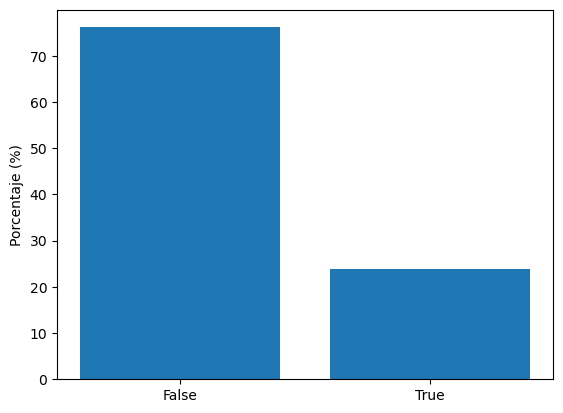

In [49]:
df['stage_worsen'] = nan_compare(df, 'stage_diagnosis', 'stage_after_neo', greater=False, equal=False)
cases = df['stage_worsen'].value_counts(dropna = True, normalize = True) * 100

plt.bar(cases.index, cases.values)
plt.xticks(cases.index, cases.index)
plt.ylabel("Porcentaje (%)")
plt.show()

In [50]:
ct = pd.crosstab(df['lobular'], df['stage_worsen'])
t, pvalue, freedom, expected = st.chi2_contingency(ct, correction = False)

print(f"T: {t: 7.4f}\t P-Value: {pvalue: .3g}")
print("H0: P(Worse Stage| Cancer Lobular) y P(Worse Stage| Cancer Ductal) son independientes.")
print(f"Expected Observations")
display(pd.DataFrame(expected, index = ct.index, columns = ct.columns).astype(int))
print("True Observations: ")
display(ct)
print("Reject H0:", pvalue < 0.05)

T:  3.1542	 P-Value:  0.0757
H0: P(Worse Stage| Cancer Lobular) y P(Worse Stage| Cancer Ductal) son independientes.
Expected Observations


stage_worsen,False,True
lobular,,
False,2747,868
True,685,216


True Observations: 


stage_worsen,False,True
lobular,,
False,2768,848
True,665,237


Reject H0: False


7 4 28


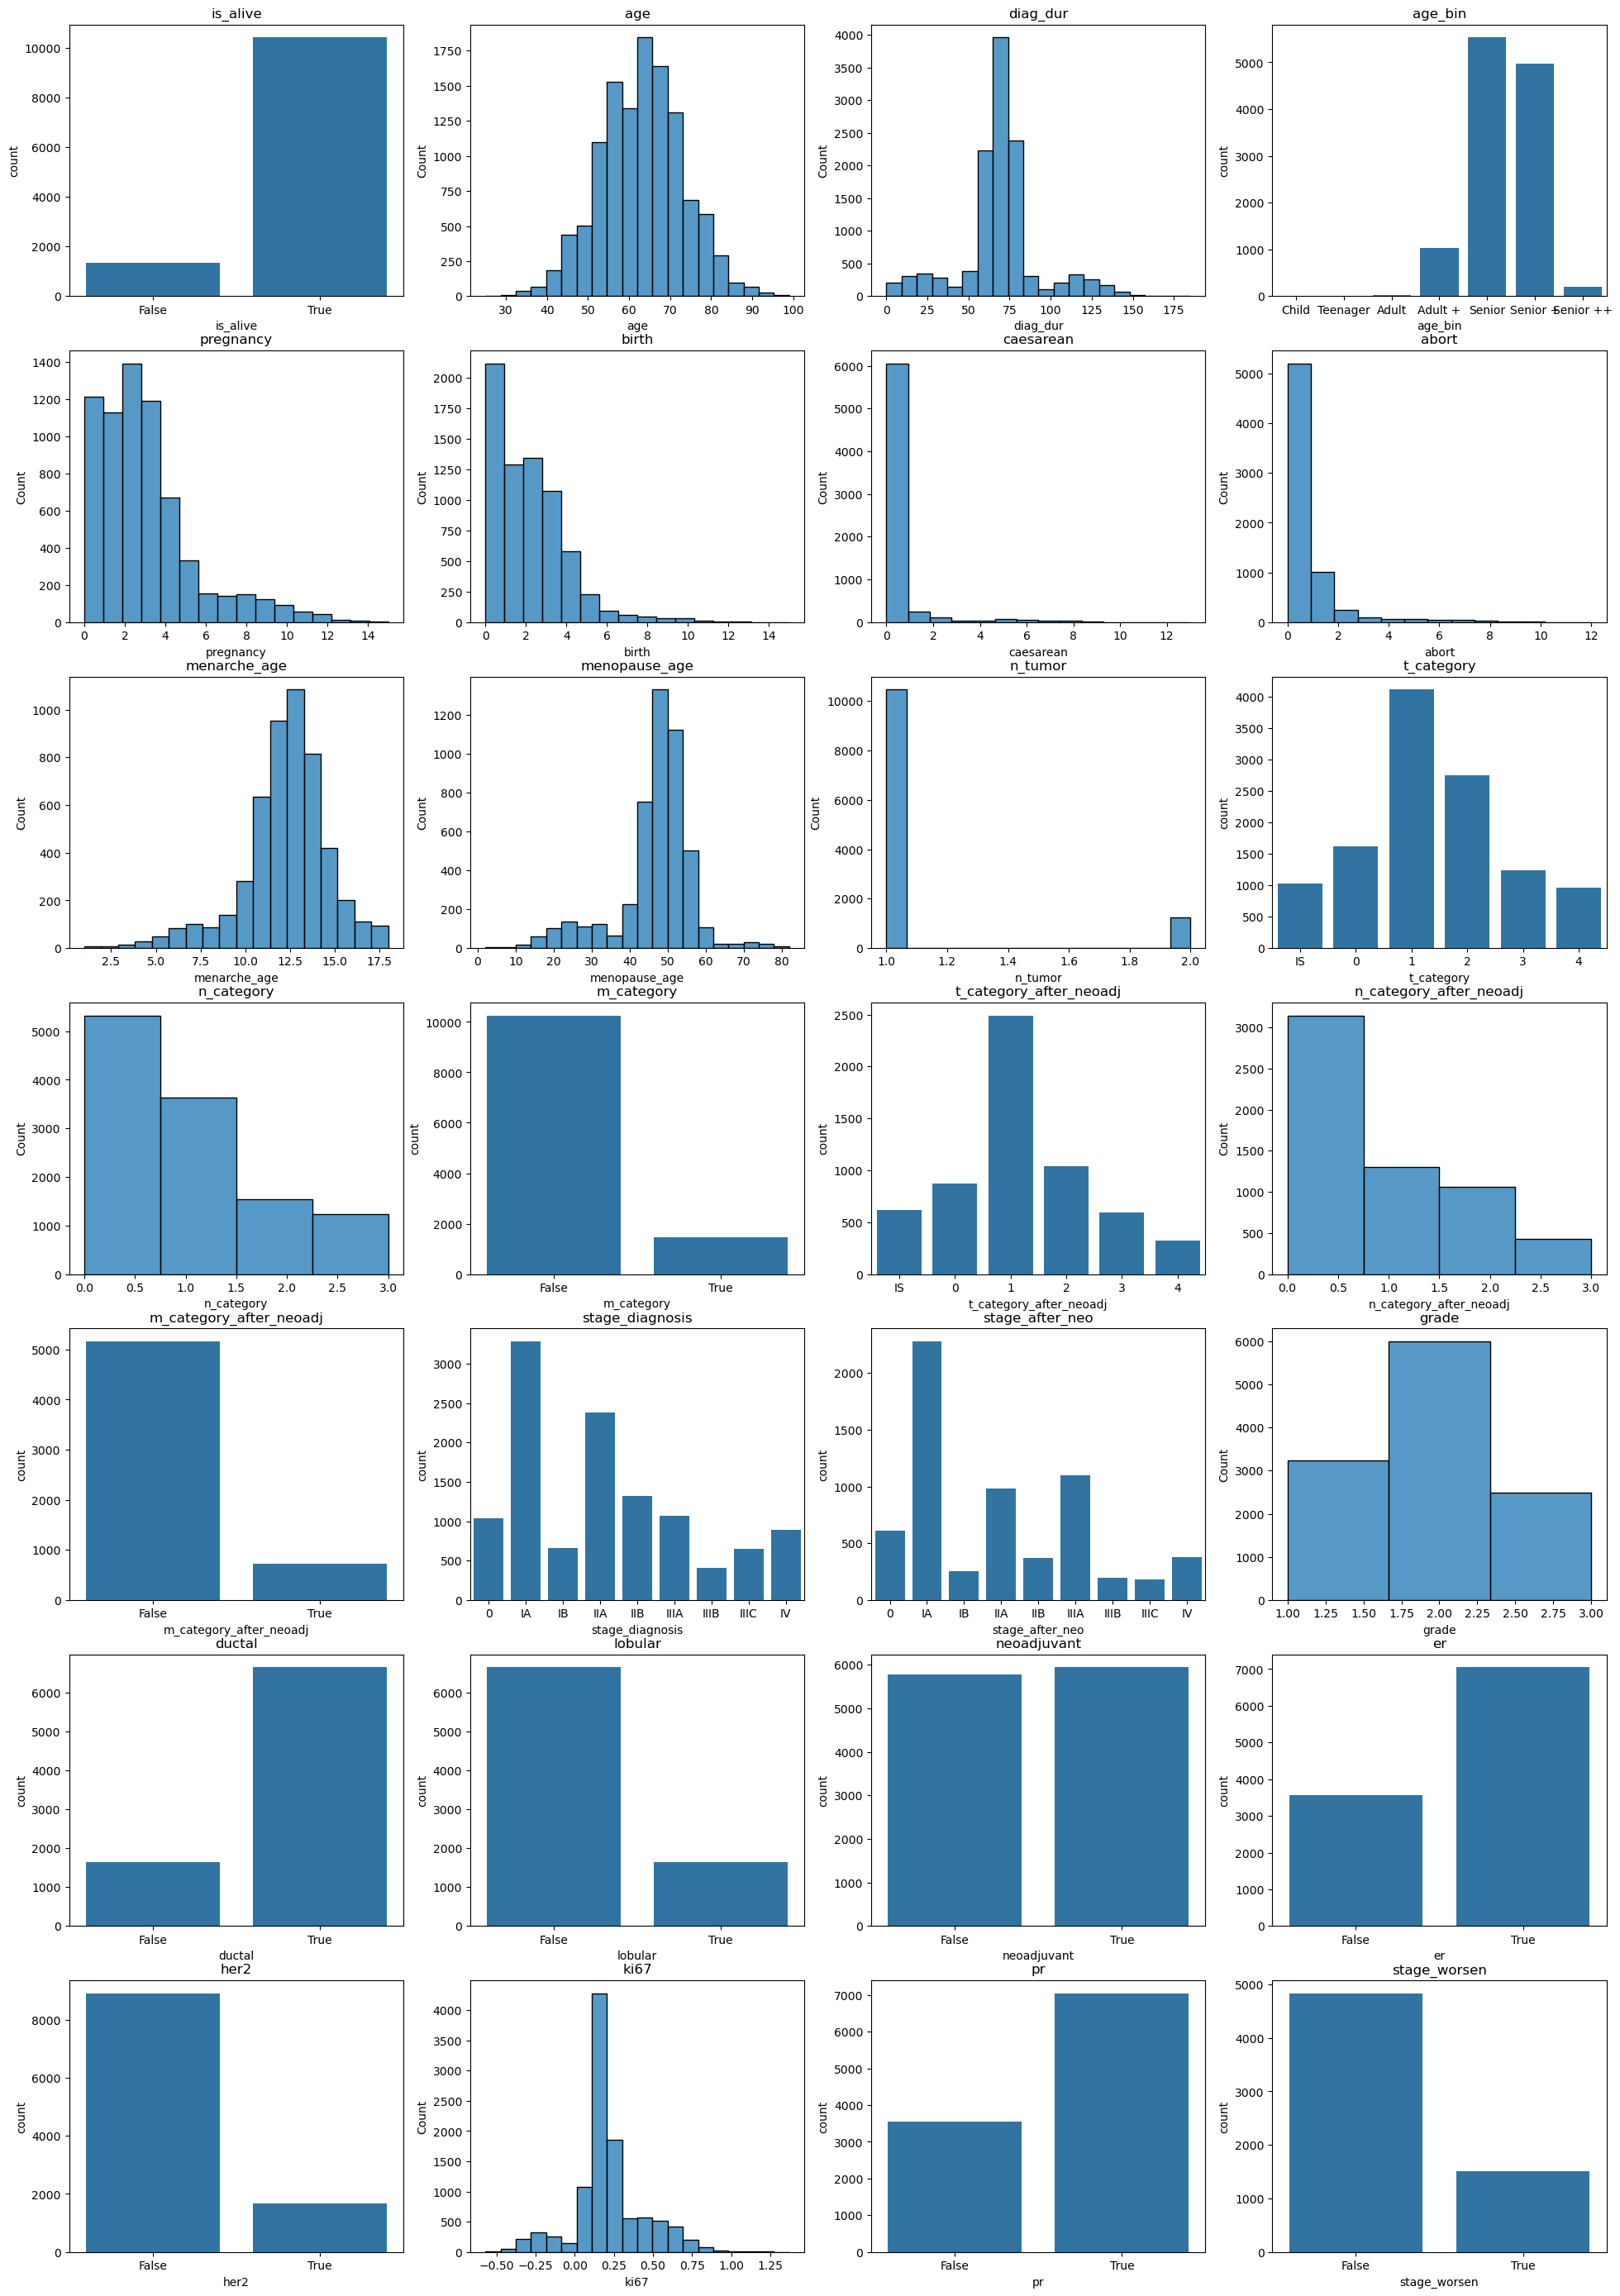

In [51]:
def plot_all_distributions(df, skip_cols = None):
    if skip_cols is None: skip_cols = []
    columns = [col for col in df.columns if col not in skip_cols]
    nvars = len(columns)

    ncol = min(nvars, 4)
    nrow = int(np.ceil(nvars / ncol))
    print(nrow, ncol, nvars)

    fig, ax = plt.subplots(nrow, ncol, figsize = (ncol * 6, nrow * 5))

    for i, column in enumerate(columns):
        row, col = divmod(i, ncol)
        if is_numeric_dtype(df[column]) and not is_bool_dtype(df[column]):
            nuni = df[column].nunique()
            bins = 'auto' if nuni == 2 else min(nuni, 20)
            sns.histplot(data = df, x = column, ax = ax[row][col], bins = bins)
        elif is_categorical_dtype(df[column]) or is_string_dtype(df[column]) or is_bool_dtype(df[column]):
            tmp_df = df.dropna(subset=[column])

            sns.countplot(data = tmp_df, x = column, ax = ax[row][col])
            if is_categorical_dtype(tmp_df[column]):
               ax[row][col].set_xticks(tmp_df[column].cat.categories)
            else:
               ax[row][col].set_xticks(tmp_df[column].unique())

        ax[row][col].set_title(column)

    for h in range(nvars, ncol * nrow):
        row, col = divmod(h, ncol)
        fig.delaxes(ax[row][col])

plot_all_distributions(df, skip_cols=['ehr'])

In [52]:
tmp = df.loc[df['neoadjuvant'].values, :].copy()
tmp.head()

,ehr,is_alive,age,diag_dur,age_bin,pregnancy,birth,caesarean,abort,menarche_age,menopause_age,n_tumor,t_category,n_category,m_category,t_category_after_neoadj,n_category_after_neoadj,m_category_after_neoadj,stage_diagnosis,stage_after_neo,grade,ductal,lobular,neoadjuvant,er,her2,ki67,pr,stage_worsen
2,10020495,True,70.0,73.0,Senior +,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3,1.0,False,2,0.0,<NA>,IA,NaN,2.0,True,False,True,True,False,0.09,False,<NA>
4,10030824,True,70.0,64.0,Senior +,0.0,0.0,0.0,0.0,NaN,44.0,1.0,2,1.0,False,2,2.0,False,IIIA,IIIA,3.0,False,True,True,True,False,NaN,True,False
5,10041592,True,64.0,61.0,Senior,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1.0,False,4,0.0,False,IB,IA,2.0,True,False,True,False,False,0.65,False,False
7,10070718,True,62.0,58.0,Senior,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,1.0,False,2,3.0,False,IIA,IIIC,3.0,True,False,True,<NA>,True,0.30,False,True
8,10072646,True,61.0,72.0,Senior,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,1.0,False,1,1.0,False,IIB,IA,1.0,False,True,True,False,False,0.28,True,False


In [53]:
# Data Handleling
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_bool_dtype
from pandas.api.types import is_categorical_dtype

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Statistical Analysis
import scipy.stats as st
import statsmodels.stats.api as stats
import statsmodels.formula.api as smf
from sksurv.nonparametric import kaplan_meier_estimator

# Warnings and Messages
from warnings import simplefilter
simplefilter('ignore', category=DeprecationWarning)
simplefilter('ignore', category=FutureWarning)
from logging import warning as warn

# Print Options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1200)
np.set_printoptions(precision = 3, edgeitems=20, linewidth=300)


<AxesSubplot:xlabel='stage_after_neo', ylabel='stage_diagnosis'>

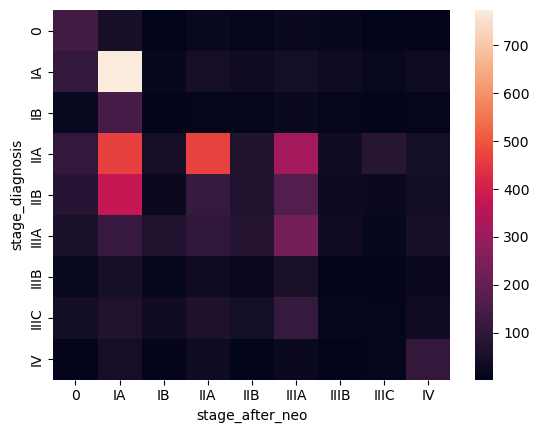

In [54]:
sns.heatmap(pd.crosstab(tmp['stage_diagnosis'], tmp['stage_after_neo']))

In [55]:
import prince

                            0         1
stage_diagnosis                        
0               -3.695348e-16 -0.707107
IA               1.826692e-13 -0.707107
IB              -3.168847e-14 -0.707107
IIA             -1.832109e+00  1.414214
IIB             -4.919700e-01  1.414214
IIIA             2.324079e+00  1.414214
IIIB             1.560537e-14 -0.707107
IIIC            -2.241839e-13 -0.707107
IV              -1.061229e-13 -0.707107
                     0         1
0_7      -1.061086e-13 -0.707107
0_19     -8.005590e-15 -0.707107
0_39     -2.236709e-13 -0.707107
0_54      2.324079e+00  1.414214
0_79     -4.919700e-01  1.414214
0_107    -1.832109e+00  1.414214
0_109     1.830481e-13 -0.707107
0_135     0.000000e+00 -0.707107
IA_47    -1.061086e-13 -0.707107
IA_49     0.000000e+00 -0.707107
IA_50     1.591169e-14 -0.707107
IA_68    -2.236709e-13 -0.707107
IA_115    2.324079e+00  1.414214
IA_148   -3.192287e-14 -0.707107
IA_376   -4.919700e-01  1.414214
IA_465   -1.832109e+00  1.414214

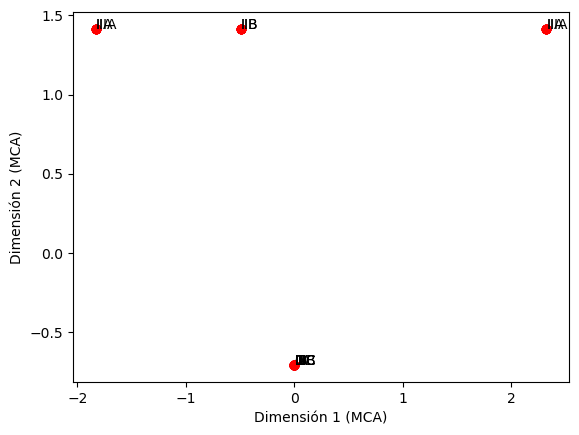

In [56]:
ct = pd.crosstab(tmp['stage_diagnosis'], tmp['stage_after_neo'])
ca = prince.MCA()
ca = ca.fit(ct)

coordenadas_categorias = ca.row_coordinates(ct)
print(coordenadas_categorias)
plt.scatter(coordenadas_categorias[0], coordenadas_categorias[1], color = 'b')
for i, txt in enumerate(ct.index):
    plt.annotate(txt, (coordenadas_categorias.iloc[i, 0], coordenadas_categorias.iloc[i, 1]))

coordenadas_categorias = ca.column_coordinates(ct)
plt.scatter(coordenadas_categorias[0], coordenadas_categorias[1], color = 'r')
print(coordenadas_categorias)
for i, txt in enumerate(ct.columns):
    plt.annotate(txt, (coordenadas_categorias.iloc[i, 0], coordenadas_categorias.iloc[i, 1]))

# Añadir etiquetas a los ejes
plt.xlabel('Dimensión 1 (MCA)')
plt.ylabel('Dimensión 2 (MCA)')

# Mostrar el gráfico
plt.show()